<a href="https://colab.research.google.com/github/Sv3t12/Trajectory_prediction/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor

In [6]:
#Все значения принимаются и выводятся в СИ

# Функция physics_model

1. Проекция скорости тела на ось X:
$$
{v_x} = {v_0}*{cos (\alpha)}
$$


2. Проекция скорости тела на ось Y:
$$
{v_y} = {v_0}*{sin (\alpha)}
$$


3. Общий вектор скорости:
$$
{v} = \sqrt{v_x^2 * v_y^2}
$$


4. Сила лобового сопротивления:
$$
{F_D} = \frac{1}{2}{\rho}{v^2}{C_D}{A}
$$


5. Ускорение по оси X:
$$
{a_x} = -\frac{F_D}{m} * \frac{v_x}{v}
$$


6. Ускорение по оси Y:
$$
{a_y} = -{g}-\frac{F_D}{m} * \frac{v_y}{v}
$$


7. Изменение проекции скорости на ось X за промежуток  ∆t:
$$
{v_x} ← {v_x} + {a_x* \Delta t}
$$


8. Изменение проекции скорости на ось Y за промежуток  ∆t:
$$
{v_y} ← {v_y} + {a_y* \Delta t}
$$


9. Изменение координаты на ось X за промежуток  ∆t:
$$
{x} ← {x} + {v_x* \Delta t}
$$


10. Изменение координаты на ось Y за промежуток  ∆t:
$$
{y} ← {y} + {v_y* \Delta t}
$$

In [7]:
def physics_model(v0, angle, C_d, mass, A=0.01, dt=0.0001):
  '''
  physics_model(v0[m/s], angle[degree], C_d, mass[kg], A=0.01, dt=0.01[s])
  Функция physics_model получает значения v0(начальной скорости),
  angle(угла наклона), C_d(коэф сопротивления), mass(массы).
  С помощью уравнений Эйлера находит траекторию полета объекта.
  Возвращает массив trajectory с координатами x,y.
  '''
  import numpy as np
  angle_rad = np.radians(angle)
  g = 9.80665 #Ускорение свободного падения [m/s**2]
  rho = 1.225 #Плотность воздуха [kg/m**3]
  vx = v0 * np.cos(angle_rad) #Проекция скорости тела на ось X
  vy = v0 * np.sin(angle_rad) #Проекция скорости тела на ось Y
  x, y = 0, 0 #Координата тела по оси X и Y
  trajectory = [[0,0]]
  while y >= 0:
      v = np.sqrt(vx**2 + vy**2) #Общий вектор скорости
      F_drag = 0.5 * rho * C_d * A * v**2 #Сила лобового сопротивления
      ax = -(F_drag / mass) * (vx / v) #Ускорение по оси X
      ay = -g - (F_drag / mass) * (vy / v) #Ускорение по оси Y
      #Изменение скорости за промежуток dt
      vx += ax * dt
      vy += ay * dt
      #Изменение координаты за промежуток dt
      if (vy * dt + y) >= 0:
        x += vx * dt
        y += vy * dt
      else:
        y = 0
        break
      trajectory.append([x, y])
  return np.array(trajectory)

#  Функция hybrid_predict

In [8]:
def hybrid_predict(v0, angle, mass, C_d, wind):
  """
  hybrid_predict(v0[m/s], angle[degree], mass[kg], C_d, wind[m/s])
  Функция получает значения v0(начальной скорости),
  angle(угла наклона), C_d(коэф сопротивления), mass(массы),
  wind(ветра).
  Находит ошибку в дальности полета согласно модели и корректирует
  Возвращает скорректированную дальность полета x_hybrid,
  траекторию физ. модели physics_traj
  """
  physics_traj = physics_model(v0, angle, C_d, mass)
  x_physics = physics_traj[-1, 0] #Конечная точка полета

  input_features = [[v0, angle, mass, C_d, wind, x_physics]]
  error = model.predict(input_features)[0]

  x_hybrid = x_physics + error #Создание гибридной конечной точки
  return x_hybrid, physics_traj

# Работа с моделью обучения

Таблица ballistic_dataset, указанная в репозитории содержит следующие признаки для 5000 случаев:


* `v0` - начальное значение скорости(м/с)
* `angle` - угол наклона тела(°)
* `C_d` - коэффицент сопротивления формы
* `mass` - масса тела(кг)
* `wind` - скорость ветра(м/с)
* `x_physics` - конечная точка полета согласно расчетам(м)
* `x_real` - реальная точка полета согласно измерениям(м)



In [9]:
#Обрабатывание датасета
df = pd.read_csv('ballistic_dataset.csv')
df['error'] = df['x_real'] - df['x_physics']
X = df[['v0', 'angle', 'C_d', 'mass', 'wind', 'x_physics']]
Y = df['error']

In [ ]:
#Обучение модели
model = CatBoostRegressor(iterations=500, learning_rate=0.05, verbose=100)
model.fit(X, Y)

# Создание рассчета по данным

In [20]:
#Демо данные для теста
v0=10
angle=45
mass=1.0
C_d=0.5
wind=5.0

In [16]:
#Ввод собственных данных
v0 = float(input('Введите начальную скорость(м/с): '))
angle = float(input('Угол наклона(°): '))
mass = float(input('Масса тела(кг): '))
C_d = float(input('Коэф. сопротивления: '))
wind = float(input('Скорость ветра(м/с): '))

Введите начальную скорость(м/с): 5
Угол наклона(°): 120
Масса тела(кг): 2
Коэф. сопротивления: 0.5
Скорость ветра(м/с): 1


In [21]:
#Получение искомых значений
x_hybrid, physics_traj = hybrid_predict \
 (v0, angle, mass, C_d, wind)

# График полета

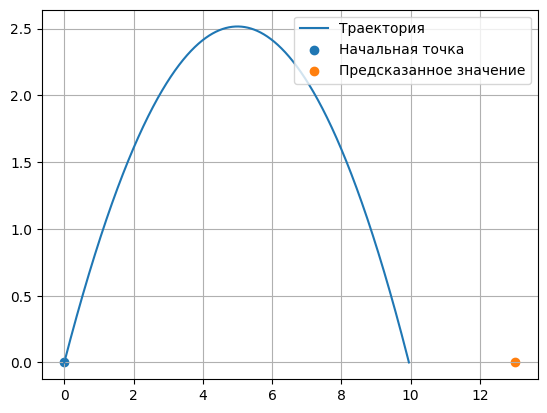

In [22]:
#Создание графика полета
plt.plot(physics_traj[:, 0], physics_traj[:, 1], label='Траектория')
plt.scatter(0, 0, label='Начальная точка')
plt.scatter(x_hybrid, 0, label='Предсказанное значение')
plt.grid()
plt.legend()